In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Install the gdown package
This code cell installs the `gdown` package, which allows downloading files from Google Drive using a command-line interface.


In [2]:
!pip install gdown

## Download the UNR-IDD Dataset
This code cell downloads the University of Nevada - Reno Intrusion Detection Dataset (UNR-IDD) from Google Drive using the `gdown` package. This dataset is commonly used for research in intrusion detection systems.


In [3]:
!gdown --id 1ANnT1g7NjbGGOvL1uHDHEQF_Dzx9kK3f

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ANnT1g7NjbGGOvL1uHDHEQF_Dzx9kK3f
To: /kaggle/working/UNR-IDD.csv
100%|██████████████████████████████████████| 5.39M/5.39M [00:00<00:00, 39.9MB/s]


## Load and Inspect the UNR-IDD Dataset
This code cell loads the UNR-IDD dataset from a CSV file into a Pandas DataFrame and displays the first few rows. It also counts the occurrences of each category in the 'Label' and 'Binary Label' columns to analyze the distribution of classes in the dataset.

In [4]:
unridd = pd.read_csv('UNR-IDD.csv')

In [5]:
unridd.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,True,0,7,489,403,-1,TCP-SYN,Attack


In [6]:
unridd['Label'].value_counts()

Label
PortScan     9500
TCP-SYN      9081
Blackhole    8420
Diversion    5615
Normal       3773
Overflow     1022
Name: count, dtype: int64

In [7]:
unridd['Binary Label'].value_counts()

Binary Label
Attack    33638
Normal     3773
Name: count, dtype: int64

## Split the Dataset into Training, Validation, and Test Sets
This code cell uses the `train_test_split` function from Scikit-learn to split the UNR-IDD dataset into training, validation, and test sets. It performs a stratified split based on the 'Binary Label' column to ensure that each set has a proportional representation of the classes. The dataset is first divided into training (70%) and a temporary set (30%), which is then split into validation and test sets (50% each).

### Objective

The goal is to classify network traffic into different categories for intrusion detection. We have two classification tasks:
1. **Multi-Class Classification**: Identifying specific types of network behavior or attacks.
   - Classes include:
     - **Normal**: Normal Network Functionality
     - **TCP-SYN**: TCP-SYN Flood
     - **PortScan**: Port Scanning
     - **Overflow**: Flow Table Overflow
     - **Blackhole**: Blackhole Attack
     - **Diversion**: Traffic Diversion Attack

2. **Binary Classification**: Detecting whether network traffic is normal or indicative of an attack.
   - Classes include:
     - **Normal**: Normal Network Functionality
     - **Attack**: Network Intrusion

### Rationale for Separate Data Splits

Given the imbalance in the dataset labels, separate splitting for binary and multi-class classification tasks is preferred for the following reasons:

1. **Preserving Label Distribution**:
   - The `stratify` parameter ensures that each split maintains the original label distribution. By splitting the binary and multi-class datasets separately, we maintain a balanced representation in the training, validation, and test sets for each classification task.

2. **Tailored Handling of Imbalanced Data**:
   - Binary classification has a different level of label imbalance compared to multi-class classification. This separation allows us to implement specific techniques to handle imbalance, such as resampling or class weighting, based on the requirements of each task.

3. **Independent Model Training and Evaluation**:
   - Splitting the datasets separately enables us to design and optimize models specifically for binary and multi-class classification without interference. This independent approach simplifies experimentation and analysis.

4. **Avoiding Data Leakage**:
   - By splitting the datasets for each task independently, we prevent any potential data leakage that could arise from combining the data processing pipelines. This ensures that the test set remains completely unseen by the model during training.

### Implementation

The following steps are taken to split the datasets:

1. **Data Splitting for Multi-Class Classification**:
   - Use `train_test_split` with the `stratify` parameter on the original multi-class labels to create training, validation, and test sets. This ensures the label proportions are preserved across the splits.

2. **Data Splitting for Binary Classification**:
   - Repeat the same process, but this time using the binary labels (`Normal` vs. `Attack`). This ensures that the label distribution for the binary classification problem is also maintained across the splits.

3. **Separate Data Processing Pipelines**:
   - After splitting, preprocess the features separately for the binary and multi-class datasets. This includes encoding categorical features, scaling numerical features, and applying techniques to handle imbalance.

---

By following this strategy, we can build models that are better suited to the specific challenges of both binary and multi-class network intrusion detection tasks.

In [8]:
from sklearn.model_selection import train_test_split

# For stratified split, use 'stratify' parameter with the target column
train_data, temp_data = train_test_split(unridd, test_size=0.3, stratify=unridd['Label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['Label'], random_state=42)

In [9]:
train_data_binary, temp_data_binary = train_test_split(unridd, test_size=0.3, stratify=unridd['Binary Label'], random_state=42)
val_data_binary, test_data_binary = train_test_split(temp_data_binary, test_size=0.5, stratify=temp_data_binary['Binary Label'], random_state=42)

In [10]:
train_data.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
13082,of:0000000000000003,Port#:4,3443,63209755,19046715,1657,1276,0,0,0,...,0,0,True,0,6,8787,8667,-1,Blackhole,Attack
18048,of:000000000000000b,Port#:1,2405,56784372,50654563,3554,1792,0,0,0,...,0,0,True,0,4,8434,8275,-1,Diversion,Attack
34799,of:0000000000000003,Port#:1,134,9321,6321901,315,151,0,0,0,...,0,0,True,0,10,165832,165732,-1,PortScan,Attack
14865,of:0000000000000003,Port#:1,152,10705,6319554,337,96,0,0,0,...,0,0,True,0,8,1400,1308,-1,Blackhole,Attack
19214,of:0000000000000001,Port#:3,4026,57008670,44390106,3506,2467,0,0,0,...,6302618,0,True,0,6,17031,16807,-1,Diversion,Attack


## Prepare Feature and Target Variables
This code cell separates the features and target variables from the training, validation, and test datasets. It drops the 'Label' and 'Binary Label' columns from the feature sets, creating `X_train`, `X_val`, and `X_test`. The corresponding target variables are stored in `y_train`, `y_val`, and `y_test` for multi-class and binary classification tasks.

In [11]:
X_train = train_data.drop(['Label', 'Binary Label'], axis=1)
y_train = train_data['Label']
X_train_binary = train_data_binary.drop(['Label', 'Binary Label'], axis=1)
y_train_binary = train_data_binary['Binary Label']

X_val = val_data.drop(['Label', 'Binary Label'], axis=1)
y_val = val_data['Label']
X_val_binary = val_data_binary.drop(['Label', 'Binary Label'], axis=1)
y_val_binary = val_data_binary['Binary Label']

X_test = test_data.drop(['Label', 'Binary Label'], axis=1)
y_test = test_data['Label']
X_test_binary = test_data_binary.drop(['Label', 'Binary Label'], axis=1)
y_test_binary = test_data_binary['Binary Label']

X_train

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size
13082,of:0000000000000003,Port#:4,3443,63209755,19046715,1657,1276,0,0,0,...,0,0,0,0,True,0,6,8787,8667,-1
18048,of:000000000000000b,Port#:1,2405,56784372,50654563,3554,1792,0,0,0,...,0,0,0,0,True,0,4,8434,8275,-1
34799,of:0000000000000003,Port#:1,134,9321,6321901,315,151,0,0,0,...,0,0,0,0,True,0,10,165832,165732,-1
14865,of:0000000000000003,Port#:1,152,10705,6319554,337,96,0,0,0,...,0,0,0,0,True,0,8,1400,1308,-1
19214,of:0000000000000001,Port#:3,4026,57008670,44390106,3506,2467,0,0,0,...,6302618,0,6302618,0,True,0,6,17031,16807,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,of:000000000000000a,Port#:3,130,17526,6330223,436,141,0,0,0,...,0,0,0,0,True,0,9978,1471,1363,-1
36139,of:0000000000000001,Port#:4,120172,12809764,18936278,722,231,0,0,0,...,0,0,0,0,True,0,8,242665,242559,-1
16921,of:0000000000000004,Port#:3,1354,25291870,6372312,712,722,0,0,0,...,0,0,0,0,True,0,6,3719,3602,-1
18873,of:0000000000000003,Port#:1,251,16978,12636468,609,254,0,0,0,...,6942,640,6942,640,True,0,6,2756,2610,-1


## Analyze Feature Distributions
This code cell analyzes the distribution of values in specific features of the training dataset. It counts the occurrences of unique values in the 'Port Number', 'Switch ID', and 'is_valid' columns. Additionally, it displays the values of the first row in the feature set `X_train` to provide insight into the data structure.

In [12]:
X_train['Port Number'].value_counts()

Port Number
Port#:2    8321
Port#:1    8291
Port#:3    6233
Port#:4    3342
Name: count, dtype: int64

In [13]:
X_train['Switch ID'].value_counts()

Switch ID
of:000000000000000c    3841
of:000000000000000a    3613
of:0000000000000003    3460
of:0000000000000001    2635
of:0000000000000004    2389
of:0000000000000007    1840
of:000000000000000b    1731
of:0000000000000008    1522
of:0000000000000005    1455
of:0000000000000002    1294
of:0000000000000006    1209
of:0000000000000009    1198
Name: count, dtype: int64

In [14]:
X_train['is_valid'].value_counts()

is_valid
True    26187
Name: count, dtype: int64

In [15]:
X_train.iloc[0]

Switch ID                        of:0000000000000003
Port Number                                  Port#:4
Received Packets                                3443
Received Bytes                              63209755
Sent Bytes                                  19046715
Sent Packets                                    1657
Port alive Duration (S)                         1276
Packets Rx Dropped                                 0
Packets Tx Dropped                                 0
Packets Rx Errors                                  0
Packets Tx Errors                                  0
Delta Received Packets                             4
Delta Received Bytes                             556
Delta Sent Bytes                                 556
Delta Sent Packets                                 4
Delta Port alive Duration (S)                      5
Delta Packets Rx Dropped                           0
 Delta Packets Tx Dropped                          0
Delta Packets Rx Errors                       

## Encode Categorical Features
This code cell uses the `LabelEncoder` from Scikit-learn to convert categorical features in the training, validation, and test datasets into numerical format. It encodes the 'Switch ID' and 'Port Number' columns for the training set and applies the same transformations to the validation and test sets. After encoding, the original categorical columns are dropped, resulting in `X_train_numeric`, `X_val_numeric`, and `X_test_numeric`, which contain only numerical features for further analysis and model training.


In [16]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for both features
le_switch = LabelEncoder()
le_port = LabelEncoder()

# Fit and transform the training data for regular labels
X_train['Switch ID Encoded'] = le_switch.fit_transform(X_train['Switch ID'])
X_train['Port Number Encoded'] = le_port.fit_transform(X_train['Port Number'])

# Transform the validation and test data using the fitted LabelEncoders
X_val['Switch ID Encoded'] = le_switch.transform(X_val['Switch ID'])
X_val['Port Number Encoded'] = le_port.transform(X_val['Port Number'])

X_test['Switch ID Encoded'] = le_switch.transform(X_test['Switch ID'])
X_test['Port Number Encoded'] = le_port.transform(X_test['Port Number'])

# Drop the original categorical columns after encoding
X_train_numeric = X_train.drop(['Switch ID', 'Port Number'], axis=1)
X_val_numeric = X_val.drop(['Switch ID', 'Port Number'], axis=1)
X_test_numeric = X_test.drop(['Switch ID', 'Port Number'], axis=1)

# Repeat the encoding process for the binary datasets
X_train_binary['Switch ID Encoded'] = le_switch.fit_transform(X_train_binary['Switch ID'])
X_train_binary['Port Number Encoded'] = le_port.fit_transform(X_train_binary['Port Number'])

X_val_binary['Switch ID Encoded'] = le_switch.transform(X_val_binary['Switch ID'])
X_val_binary['Port Number Encoded'] = le_port.transform(X_val_binary['Port Number'])

X_test_binary['Switch ID Encoded'] = le_switch.transform(X_test_binary['Switch ID'])
X_test_binary['Port Number Encoded'] = le_port.transform(X_test_binary['Port Number'])

# Drop the original categorical columns after encoding in the binary datasets
X_train_numeric_binary = X_train_binary.drop(['Switch ID', 'Port Number'], axis=1)
X_val_numeric_binary = X_val_binary.drop(['Switch ID', 'Port Number'], axis=1)
X_test_numeric_binary = X_test_binary.drop(['Switch ID', 'Port Number'], axis=1)

# Display the encoded training dataset for both versions
print("Encoded Training Dataset (Regular Labels):")
print(X_train_numeric.head())

print("\nEncoded Training Dataset (Binary Labels):")
print(X_train_numeric_binary.head())

Encoded Training Dataset (Regular Labels):
       Received Packets  Received Bytes  Sent Bytes  Sent Packets  \
13082              3443        63209755    19046715          1657   
18048              2405        56784372    50654563          3554   
34799               134            9321     6321901           315   
14865               152           10705     6319554           337   
19214              4026        57008670    44390106          3506   

       Port alive Duration (S)  Packets Rx Dropped  Packets Tx Dropped  \
13082                     1276                   0                   0   
18048                     1792                   0                   0   
34799                      151                   0                   0   
14865                       96                   0                   0   
19214                     2467                   0                   0   

       Packets Rx Errors  Packets Tx Errors  Delta Received Packets  ...  \
13082                

In [17]:
X_train_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26187 entries, 13082 to 8518
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Received Packets               26187 non-null  int64
 1   Received Bytes                 26187 non-null  int64
 2   Sent Bytes                     26187 non-null  int64
 3   Sent Packets                   26187 non-null  int64
 4   Port alive Duration (S)        26187 non-null  int64
 5   Packets Rx Dropped             26187 non-null  int64
 6   Packets Tx Dropped             26187 non-null  int64
 7   Packets Rx Errors              26187 non-null  int64
 8   Packets Tx Errors              26187 non-null  int64
 9   Delta Received Packets         26187 non-null  int64
 10  Delta Received Bytes           26187 non-null  int64
 11  Delta Sent Bytes               26187 non-null  int64
 12  Delta Sent Packets             26187 non-null  int64
 13  Delta Port alive D

## Inspect Unique Values in Numeric Features
This code cell iterates through each column in the `X_train_numeric` dataset to retrieve and display the unique values along with the count of unique values for each feature. This inspection helps to understand the diversity and distribution of data within the numeric features after encoding.


In [18]:
# Check unique values for the training dataset with regular labels
print("Unique Values in Training Dataset (Regular Labels):")
for column in X_train_numeric.columns:
    unique_values = X_train_numeric[column].unique()  # Get unique values
    num_unique = len(unique_values)  # Number of unique values
    
    # Print the column name and its unique values
    print(f"\nColumn: {column}")
    print(f"Unique Values: {unique_values}")
    print(f"Number of Unique Values: {num_unique}")

# Check unique values for the training dataset with binary labels
print("\nUnique Values in Training Dataset (Binary Labels):")
for column in X_train_numeric_binary.columns:
    unique_values = X_train_numeric_binary[column].unique()  # Get unique values
    num_unique = len(unique_values)  # Number of unique values
    
    # Print the column name and its unique values
    print(f"\nColumn: {column}")
    print(f"Unique Values: {unique_values}")
    print(f"Number of Unique Values: {num_unique}")


Unique Values in Training Dataset (Regular Labels):

Column: Received Packets
Unique Values: [  3443   2405    134 ... 177778 143562 120172]
Number of Unique Values: 8072

Column: Received Bytes
Unique Values: [63209755 56784372     9321 ... 12809764 25291870  6352188]
Number of Unique Values: 19168

Column: Sent Bytes
Unique Values: [19046715 50654563  6321901 ... 18936278  6372312 12636468]
Number of Unique Values: 23228

Column: Sent Packets
Unique Values: [  1657   3554    315 ... 300504   6342 153224]
Number of Unique Values: 9363

Column: Port alive Duration (S)
Unique Values: [1276 1792  151 ...  123  637  267]
Number of Unique Values: 1199

Column: Packets Rx Dropped
Unique Values: [0]
Number of Unique Values: 1

Column: Packets Tx Dropped
Unique Values: [0]
Number of Unique Values: 1

Column: Packets Rx Errors
Unique Values: [0]
Number of Unique Values: 1

Column: Packets Tx Errors
Unique Values: [0]
Number of Unique Values: 1

Column: Delta Received Packets
Unique Values: [  

## Drop Columns with a Single Unique Value
This code cell defines a function to identify and drop columns from a DataFrame that contain only a single unique value. The function is then applied to the training, validation, and test datasets (`X_train_numeric`, `X_val_numeric`, and `X_test_numeric`). After executing the function, it prints the names of the columns that were removed from each dataset, which helps in cleaning the data by eliminating redundant features.

In [19]:
# Function to drop columns with a single unique value
def drop_single_value_columns(df):
    # Get columns with only one unique value
    cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
    
    # Drop those columns
    df_dropped = df.drop(cols_to_drop, axis=1)
    
    return df_dropped, cols_to_drop

# Apply the function to training, validation, and test datasets for regular labels
X_train_numeric, dropped_train_cols = drop_single_value_columns(X_train_numeric)
X_val_numeric, dropped_val_cols = drop_single_value_columns(X_val_numeric)
X_test_numeric, dropped_test_cols = drop_single_value_columns(X_test_numeric)

# Apply the function to training, validation, and test datasets for binary labels
X_train_numeric_binary, dropped_train_binary_cols = drop_single_value_columns(X_train_numeric_binary)
X_val_numeric_binary, dropped_val_binary_cols = drop_single_value_columns(X_val_numeric_binary)
X_test_numeric_binary, dropped_test_binary_cols = drop_single_value_columns(X_test_numeric_binary)

# Display the columns that were dropped
print("Dropped columns from training set (Regular Labels):", dropped_train_cols)
print("Dropped columns from validation set (Regular Labels):", dropped_val_cols)
print("Dropped columns from test set (Regular Labels):", dropped_test_cols)

print("\nDropped columns from training set (Binary Labels):", dropped_train_binary_cols)
print("Dropped columns from validation set (Binary Labels):", dropped_val_binary_cols)
print("Dropped columns from test set (Binary Labels):", dropped_test_binary_cols)

Dropped columns from training set (Regular Labels): ['Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors', 'Delta Packets Rx Dropped', ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors', 'Delta Packets Tx Errors', 'is_valid', 'Table ID', 'Max Size']
Dropped columns from validation set (Regular Labels): ['Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors', 'Delta Packets Rx Dropped', ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors', 'Delta Packets Tx Errors', 'is_valid', 'Table ID', 'Max Size']
Dropped columns from test set (Regular Labels): ['Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors', 'Delta Packets Rx Dropped', ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors', 'Delta Packets Tx Errors', 'is_valid', 'Table ID', 'Max Size']

Dropped columns from training set (Binary Labels): ['Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors', 'Delt

In [20]:
X_train_numeric.head()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Delta Received Packets,Delta Received Bytes,Delta Sent Bytes,Delta Sent Packets,Delta Port alive Duration (S),...,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Active Flow Entries,Packets Looked Up,Packets Matched,Switch ID Encoded,Port Number Encoded
13082,3443,63209755,19046715,1657,1276,4,556,556,4,5,...,0,0,0,0,0,6,8787,8667,2,3
18048,2405,56784372,50654563,3554,1792,0,0,280,2,4,...,0,0,0,0,0,4,8434,8275,10,0
34799,134,9321,6321901,315,151,0,0,278,2,4,...,0,0,0,0,0,10,165832,165732,2,0
14865,152,10705,6319554,337,96,0,0,278,2,5,...,0,0,0,0,0,8,1400,1308,2,0
19214,4026,57008670,44390106,3506,2467,2,278,278,2,5,...,0,6302618,0,6302618,0,6,17031,16807,0,2


## Visualize Numeric Features with Boxplots
This code cell generates boxplots for each numeric feature in the `X_train_numeric` dataset. It iterates through all numeric columns, creating a boxplot for each to visualize the distribution and identify potential outliers. The plots are displayed one at a time, providing insights into the spread and central tendency of each feature.

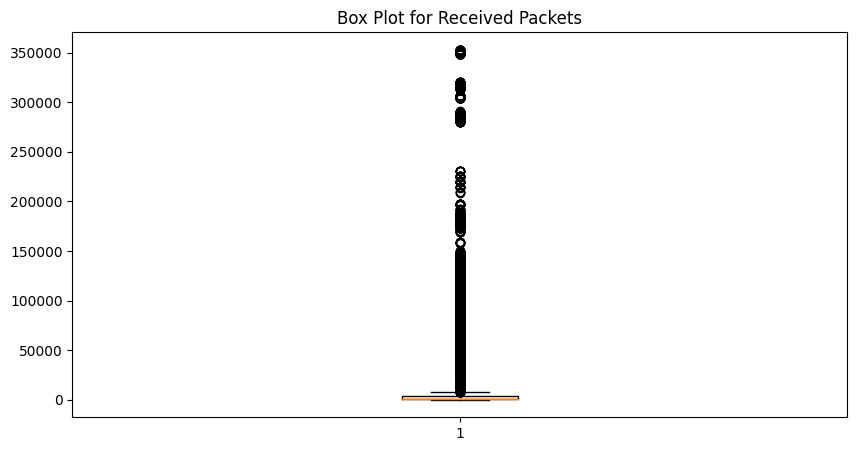

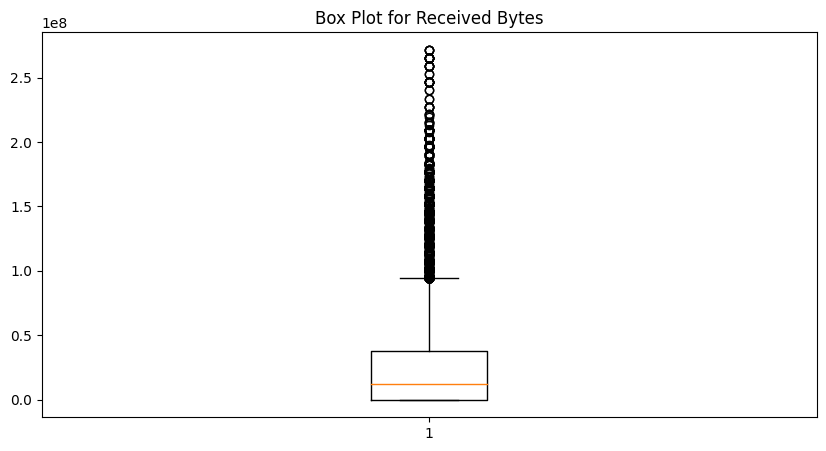

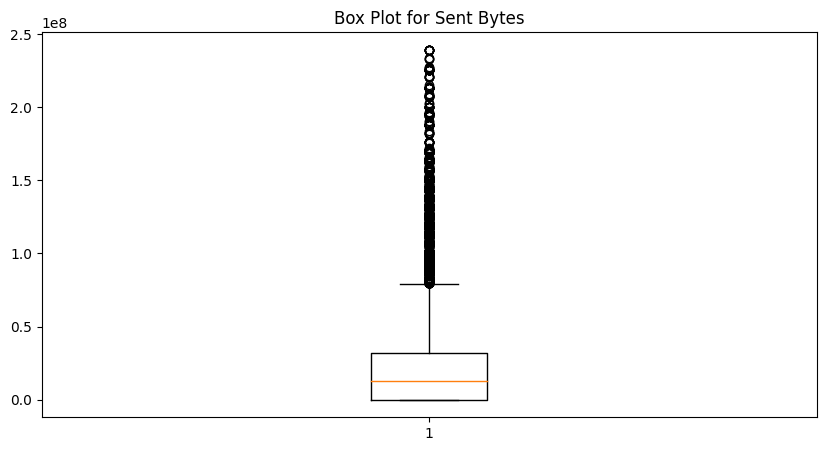

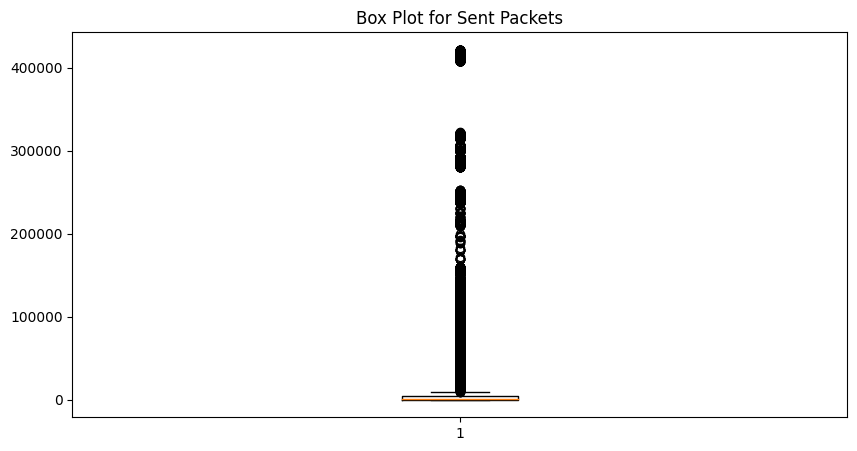

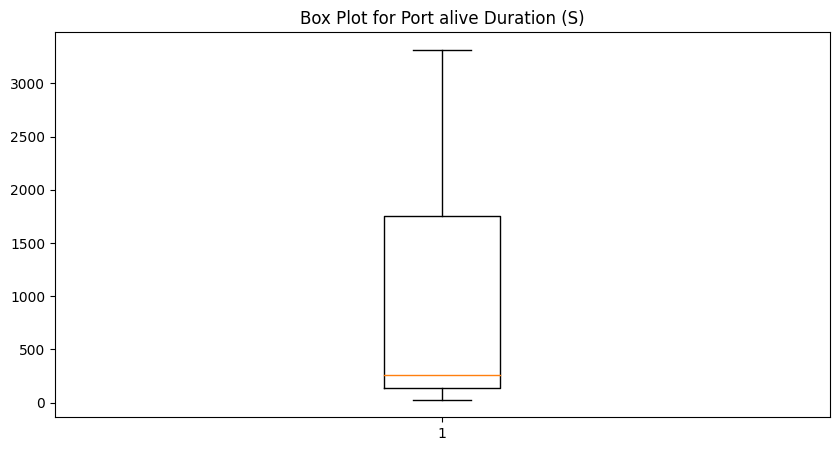

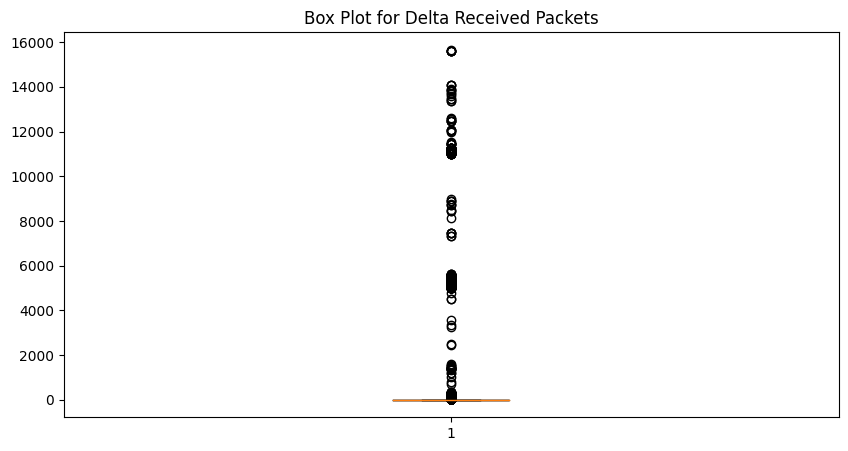

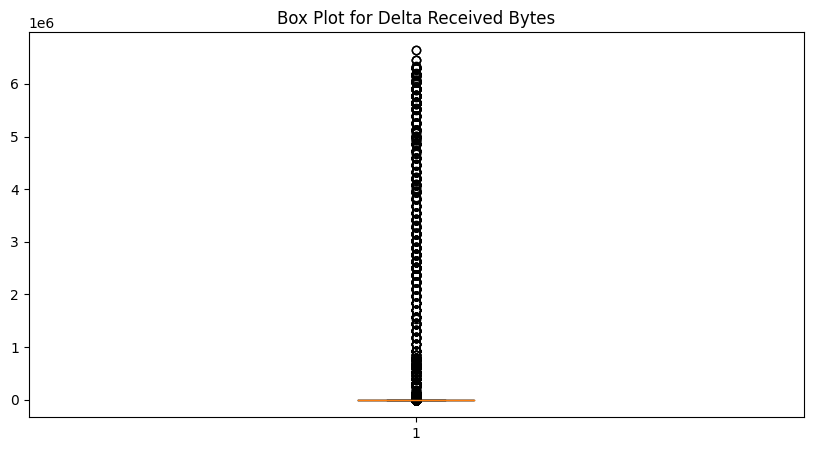

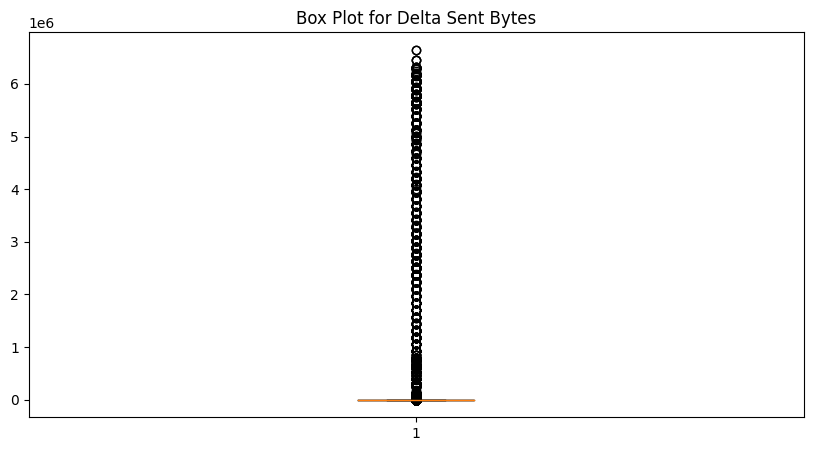

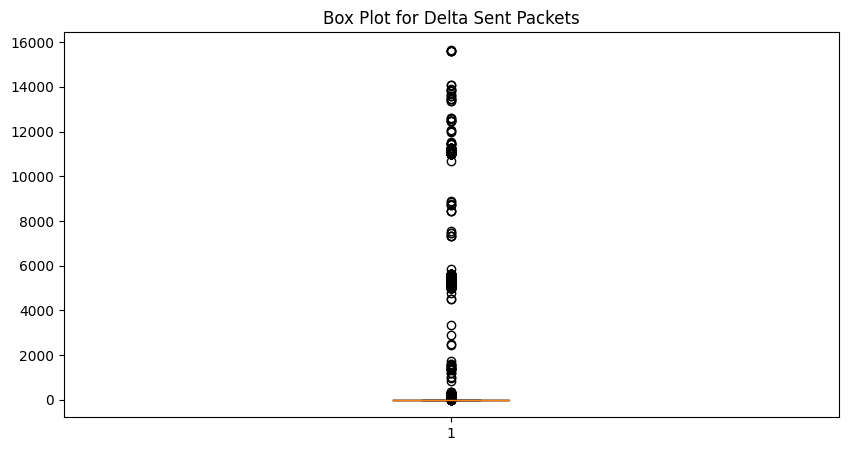

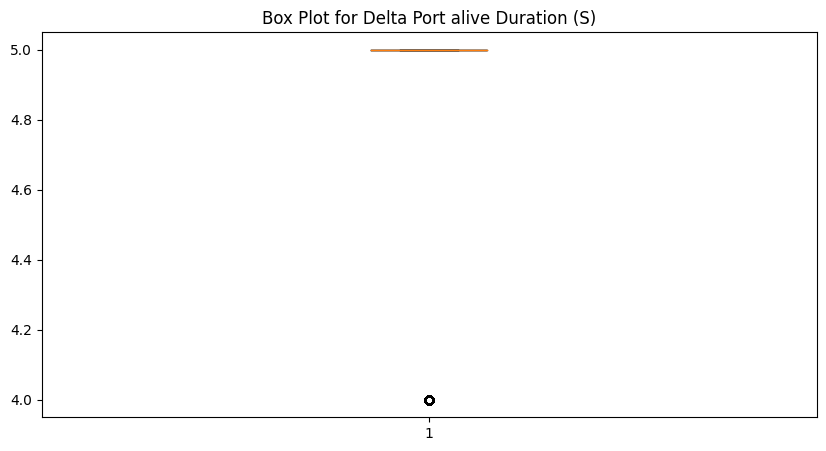

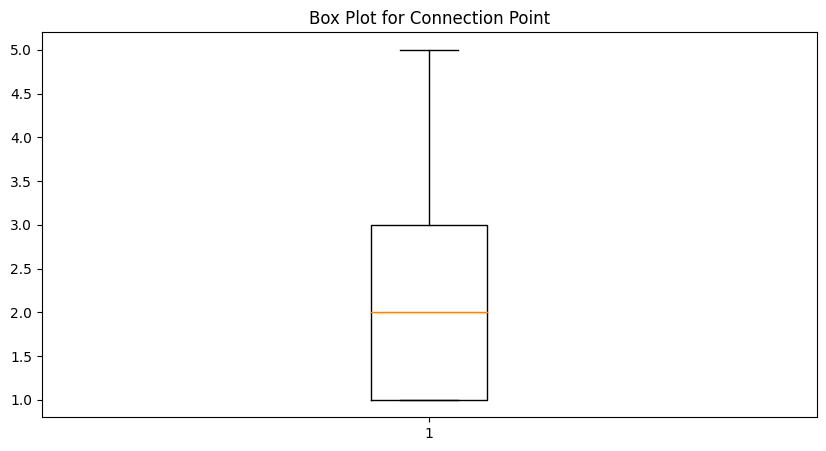

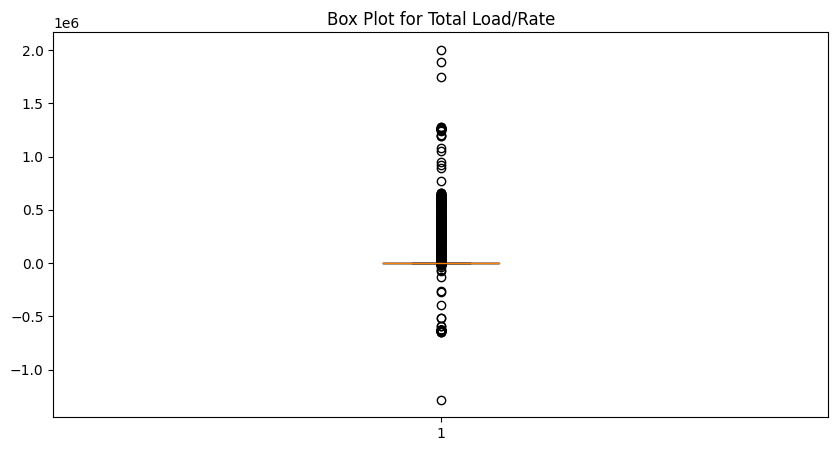

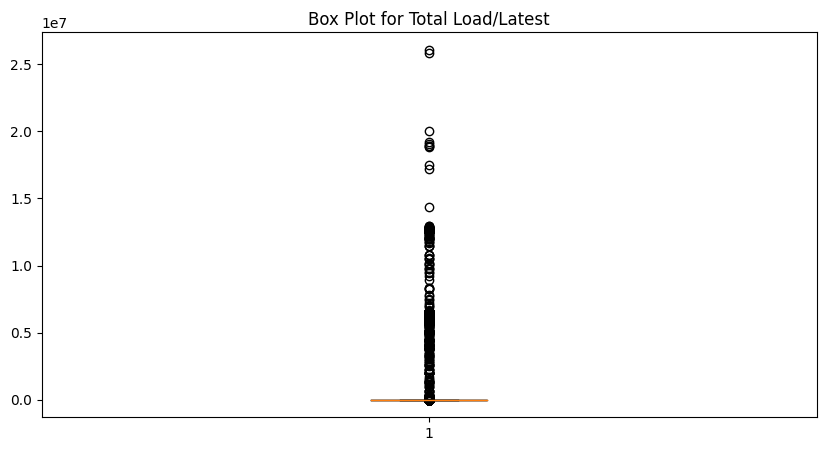

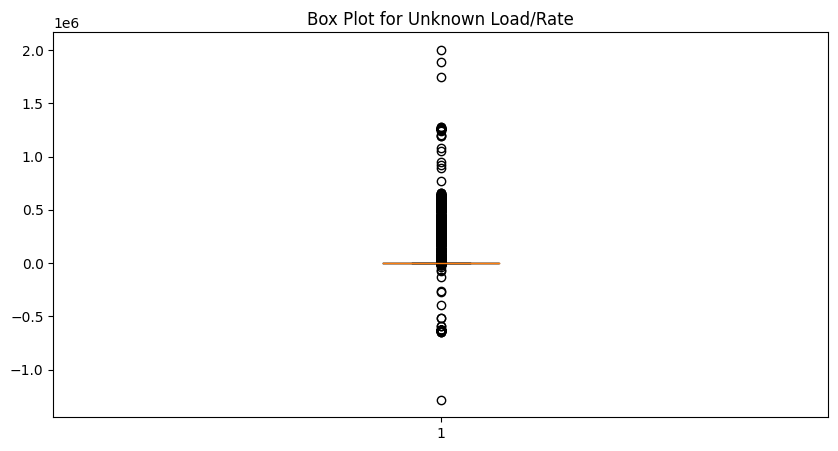

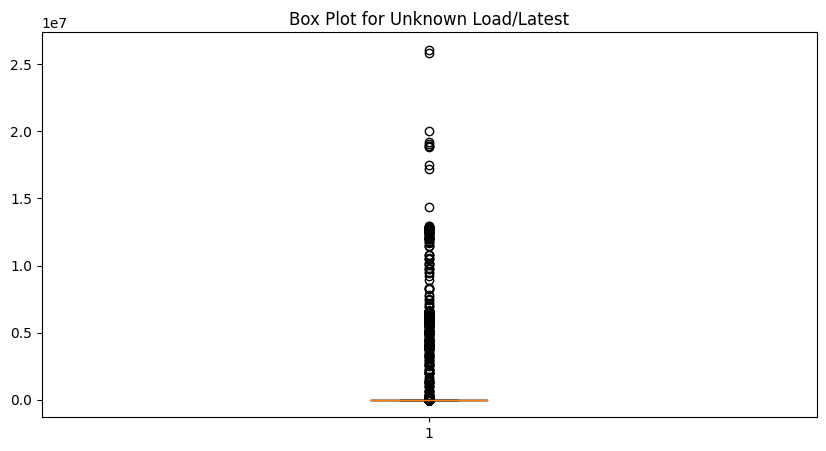

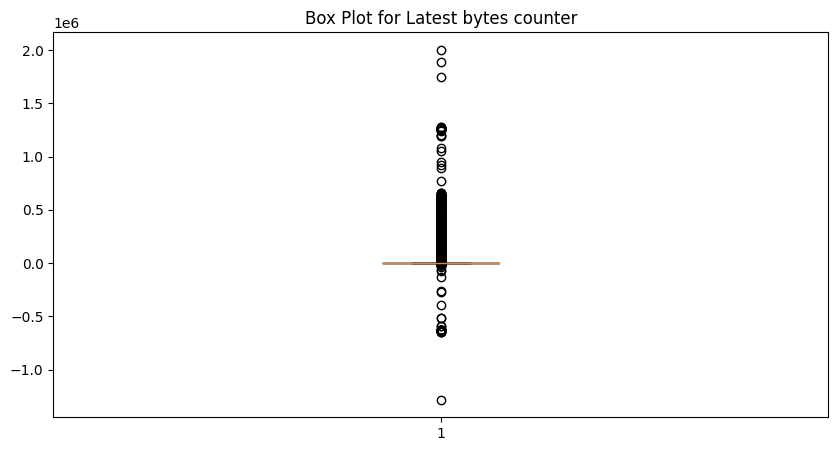

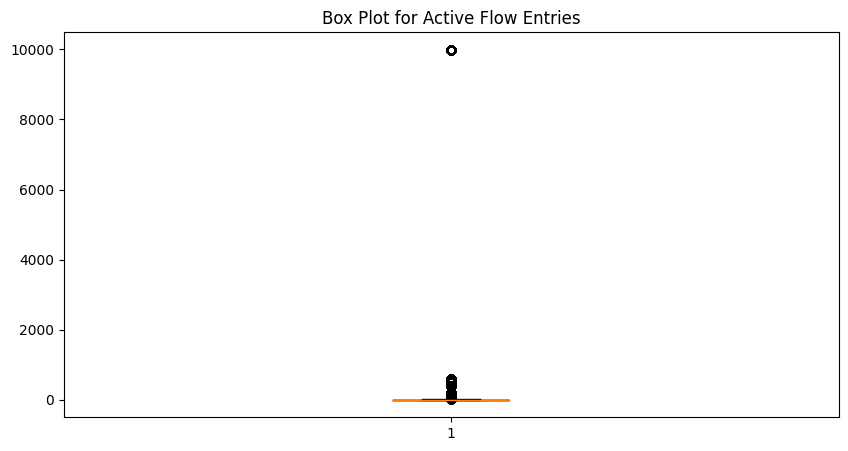

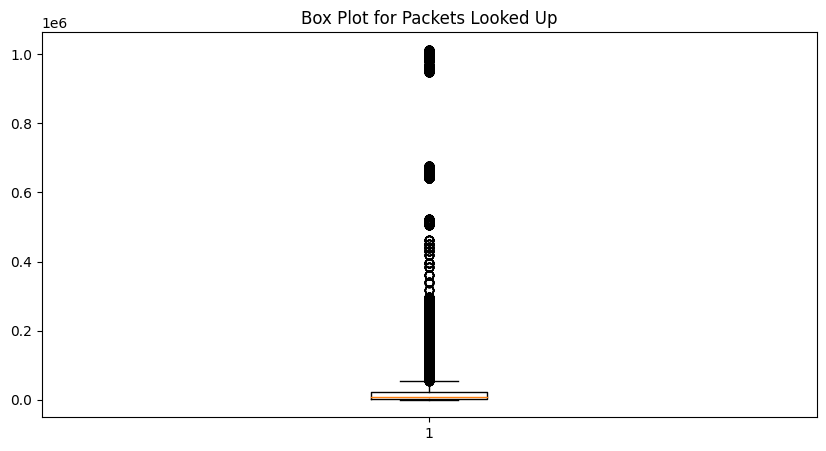

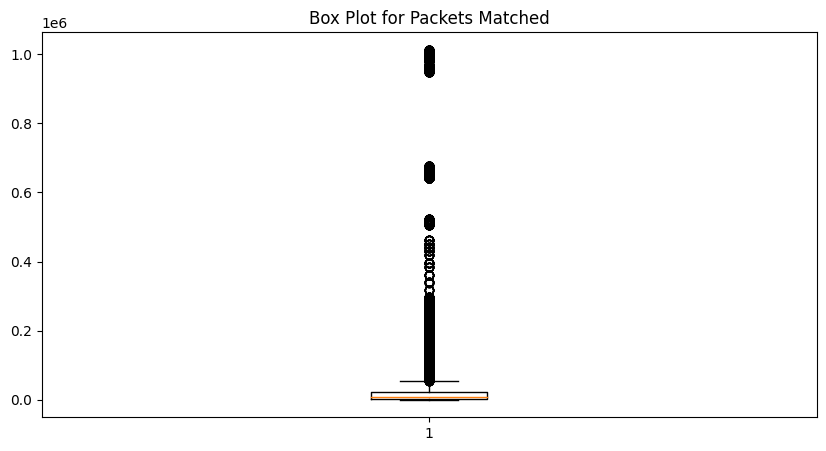

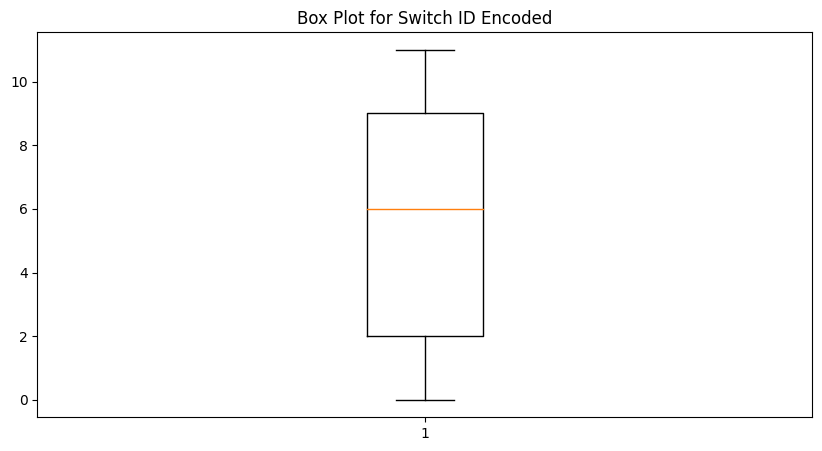

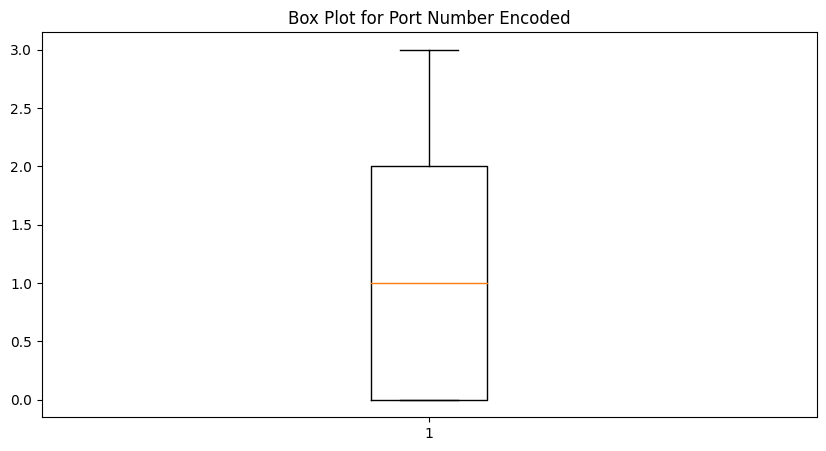

In [21]:
import matplotlib.pyplot as plt

# Plot boxplots for each numeric feature
for column in X_train_numeric.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 5))
    plt.title(f'Box Plot for {column}')
    plt.boxplot(X_train_numeric[column].dropna())
    plt.show()


## Detect Outliers Using the IQR Method
This code cell defines a function to detect outliers in a DataFrame using the Interquartile Range (IQR) method. It calculates the first (Q1) and third (Q3) quartiles for each numeric column, determines the IQR, and sets the lower and upper bounds for outlier detection. The function identifies indices of the outliers and returns them in a dictionary. Afterward, it applies the function to the `X_train_numeric` dataset and prints the number of outliers found for each column, providing insights into the data quality and potential anomalies.

In [22]:
def detect_outliers_iqr(df):
    outlier_indices = {}
    
    # Loop through each column in the DataFrame
    for column in df.select_dtypes(include=['number']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outlier_indices[column] = list(outliers)
    
    return outlier_indices

# Detect outliers in the training dataset
outliers = detect_outliers_iqr(X_train_numeric)

# Display outliers for each column
for column, outlier_list in outliers.items():
    print(f"Column: {column}, Number of Outliers: {len(outlier_list)}")


Column: Received Packets, Number of Outliers: 3286
Column: Received Bytes, Number of Outliers: 1853
Column: Sent Bytes, Number of Outliers: 2382
Column: Sent Packets, Number of Outliers: 3963
Column: Port alive Duration (S), Number of Outliers: 0
Column: Delta Received Packets, Number of Outliers: 6474
Column: Delta Received Bytes, Number of Outliers: 6425
Column: Delta Sent Bytes, Number of Outliers: 6001
Column: Delta Sent Packets, Number of Outliers: 6012
Column: Delta Port alive Duration (S), Number of Outliers: 4100
Column: Connection Point, Number of Outliers: 0
Column: Total Load/Rate, Number of Outliers: 3720
Column: Total Load/Latest, Number of Outliers: 4711
Column: Unknown Load/Rate, Number of Outliers: 3720
Column: Unknown Load/Latest, Number of Outliers: 4711
Column: Latest bytes counter, Number of Outliers: 3720
Column: Active Flow Entries, Number of Outliers: 1559
Column: Packets Looked Up, Number of Outliers: 5489
Column: Packets Matched, Number of Outliers: 5489
Column

In [23]:
X_train_numeric.describe()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Delta Received Packets,Delta Received Bytes,Delta Sent Bytes,Delta Sent Packets,Delta Port alive Duration (S),...,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Active Flow Entries,Packets Looked Up,Packets Matched,Switch ID Encoded,Port Number Encoded
count,26187.000000,2.618700e+04,2.618700e+04,26187.000000,26187.000000,26187.000000,2.618700e+04,2.618700e+04,26187.000000,26187.000000,...,2.618700e+04,2.618700e+04,2.618700e+04,2.618700e+04,2.618700e+04,26187.000000,2.618700e+04,2.618700e+04,26187.000000,26187.000000
mean,21657.737083,2.667052e+07,2.472298e+07,33707.114026,913.690113,189.775919,3.458354e+05,3.137543e+05,174.263719,4.843434,...,1.884433e+04,5.133159e+05,1.884433e+04,5.133159e+05,1.884433e+04,91.290411,1.011177e+05,1.009985e+05,5.751021,1.176653
std,65211.219031,3.710171e+07,3.457043e+07,88951.604457,984.184206,1059.880244,1.212102e+06,1.150880e+06,1010.504293,0.363398,...,1.116297e+05,1.867468e+06,1.116297e+05,1.867468e+06,1.116297e+05,805.259038,2.355511e+05,2.355499e+05,3.769238,1.016829
min,9.000000,7.860000e+02,5.705000e+03,41.000000,26.000000,0.000000,0.000000e+00,2.780000e+02,2.000000,4.000000,...,-1.284277e+06,0.000000e+00,-1.284277e+06,0.000000e+00,-1.284277e+06,4.000000,8.700000e+01,3.700000e+01,0.000000,0.000000
25%,337.000000,1.021055e+05,6.240400e+04,357.000000,136.000000,2.000000,2.780000e+02,2.800000e+02,2.000000,5.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000,2.373500e+03,2.274500e+03,2.000000,0.000000
50%,1194.000000,1.263163e+07,1.262909e+07,1267.000000,261.000000,4.000000,5.560000e+02,5.560000e+02,4.000000,5.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000,7.512000e+03,7.389000e+03,6.000000,1.000000
75%,3442.000000,3.785267e+07,3.177972e+07,4020.000000,1756.000000,6.000000,8.290000e+02,7.590000e+02,5.000000,5.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000,2.357900e+04,2.339800e+04,9.000000,2.000000
max,352772.000000,2.715925e+08,2.392430e+08,421598.000000,3317.000000,15659.000000,6.647966e+06,6.647970e+06,15659.000000,5.000000,...,2.004388e+06,2.606759e+07,2.004388e+06,2.606759e+07,2.004388e+06,9987.000000,1.012574e+06,1.012439e+06,11.000000,3.000000


## Scale Numeric Features Using Standardization
This code cell utilizes the `StandardScaler` from Scikit-learn to standardize the numeric features in the training, validation, and test datasets. The `fit_transform` method is applied to the training set to compute the mean and standard deviation for scaling, while the `transform` method is used to apply the same scaling parameters to the validation and test sets. The result is stored in `X_train_scaled`, `X_val_scaled`, and `X_test_scaled`, ensuring that the features are centered around zero with a standard deviation of one, which is essential for many machine learning algorithms.

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training, validation, and test datasets for regular labels
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_val_scaled = scaler.transform(X_val_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Scale the training, validation, and test datasets for binary labels
scaler_binary = StandardScaler()

X_train_scaled_binary = scaler_binary.fit_transform(X_train_numeric_binary)
X_val_scaled_binary = scaler_binary.transform(X_val_numeric_binary)
X_test_scaled_binary = scaler_binary.transform(X_test_numeric_binary)

# Display the scaled training dataset for regular labels
print("Scaled Training Dataset (Regular Labels):")
print(X_train_scaled)

# Display the scaled training dataset for binary labels
print("\nScaled Training Dataset (Binary Labels):")
print(X_train_scaled_binary)


Scaled Training Dataset (Regular Labels):
[[-0.2793244   0.9848583  -0.16419726 ... -0.3919901  -0.99518593
   1.79320375]
 [-0.29524221  0.81167207  0.75012319 ... -0.39365432  1.12729923
  -1.15720004]
 [-0.33006818 -0.71861128 -0.53228804 ...  0.27482409 -0.99518593
  -1.15720004]
 ...
 [-0.31135938 -0.03715943 -0.5308298  ... -0.41349339 -0.72987529
   0.80973582]
 [-0.32827397 -0.7184049  -0.34962652 ... -0.41770489 -0.99518593
  -1.15720004]
 [-0.32051442 -0.54764915 -0.71462946 ... -0.42132627  0.86198858
   1.79320375]]

Scaled Training Dataset (Binary Labels):
[[-0.32612482 -0.71096442 -0.52787881 ... -0.42633104 -1.52378828
   1.79756114]
 [ 1.72171116  0.33034581 -0.34344775 ...  0.14570003  0.06839025
  -0.17023911]
 [-0.30604529 -0.20006077  0.20669738 ... -0.40951872  0.33375334
   0.81366102]
 ...
 [-0.32528179 -0.54157839 -0.71105952 ... -0.42096215  0.33375334
   0.81366102]
 [-0.32526646 -0.5415799  -0.709621   ... -0.41756143 -0.99306211
   0.81366102]
 [-0.32635474 

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [27]:
#Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  12.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  11.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150]},
             verbose=2)

In [28]:
# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(best_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [29]:
# Model Evaluation on the validation set
y_val_pred = best_model.predict(X_val_scaled)
#y_val_pred = model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.9442266571632216
Validation Classification Report:
               precision    recall  f1-score   support

   Blackhole       0.99      0.98      0.99      1263
   Diversion       0.99      0.98      0.98       842
      Normal       1.00      1.00      1.00       566
    Overflow       0.97      0.75      0.85       154
    PortScan       0.91      0.91      0.91      1425
     TCP-SYN       0.89      0.92      0.90      1362

    accuracy                           0.94      5612
   macro avg       0.96      0.92      0.94      5612
weighted avg       0.95      0.94      0.94      5612

Validation Confusion Matrix:
 [[1242    0    0    0    9   12]
 [   2  821    0    2   12    5]
 [   0    0  566    0    0    0]
 [   7    5    0  116   12   14]
 [   0    0    0    0 1300  125]
 [   3    0    0    2  103 1254]]


In [30]:
# Testing the model on the test set
y_test_pred = best_model.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.9509978617248752
Test Classification Report:
               precision    recall  f1-score   support

   Blackhole       0.99      0.98      0.99      1263
   Diversion       1.00      0.98      0.99       843
      Normal       1.00      1.00      1.00       566
    Overflow       1.00      0.72      0.84       153
    PortScan       0.92      0.92      0.92      1425
     TCP-SYN       0.90      0.94      0.92      1362

    accuracy                           0.95      5612
   macro avg       0.97      0.92      0.94      5612
weighted avg       0.95      0.95      0.95      5612

Test Confusion Matrix:
 [[1242    0    0    0    8   13]
 [   1  824    0    0   12    6]
 [   0    0  566    0    0    0]
 [   6    3    0  110   19   15]
 [   0    0    0    0 1315  110]
 [   0    0    0    0   82 1280]]


In [31]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_numeric.columns)
feature_importances = pd.Series(best_model.feature_importances_, index=X_train_scaled.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

Feature Importances:
 Port alive Duration (S)          0.219953
Packets Looked Up                0.135161
Packets Matched                  0.131830
Sent Packets                     0.080166
Received Packets                 0.062832
Sent Bytes                       0.061675
Connection Point                 0.060962
Received Bytes                   0.052560
Active Flow Entries              0.029958
Port Number Encoded              0.027348
Switch ID Encoded                0.025718
Unknown Load/Latest              0.017425
Delta Received Bytes             0.015966
Delta Received Packets           0.015420
Total Load/Latest                0.013728
Delta Sent Bytes                 0.011751
Delta Sent Packets               0.011433
Latest bytes counter             0.009415
Total Load/Rate                  0.007490
Unknown Load/Rate                0.007020
Delta Port alive Duration (S)    0.002190
dtype: float64


In [33]:
binary_model = RandomForestClassifier(random_state=42)
binary_model.fit(X_train_scaled_binary, y_train_binary)

RandomForestClassifier(random_state=42)

In [34]:
y_val_binary_pred = binary_model.predict(X_val_scaled_binary)

print("Validation Accuracy:", accuracy_score(y_val_binary, y_val_binary_pred))
print("Validation Classification Report:\n", classification_report(y_val_binary, y_val_binary_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val_binary, y_val_binary_pred))

Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      5046
      Normal       1.00      1.00      1.00       566

    accuracy                           1.00      5612
   macro avg       1.00      1.00      1.00      5612
weighted avg       1.00      1.00      1.00      5612

Validation Confusion Matrix:
 [[5046    0]
 [   0  566]]


In [37]:
y_test_binary_pred = binary_model.predict(X_test_scaled_binary)

print("Test Accuracy:", accuracy_score(y_test_binary, y_test_binary_pred))
print("Test Classification Report:\n", classification_report(y_test_binary, y_test_binary_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test_binary, y_test_binary_pred))

Test Accuracy: 1.0
Test Classification Report:
               precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      5046
      Normal       1.00      1.00      1.00       566

    accuracy                           1.00      5612
   macro avg       1.00      1.00      1.00      5612
weighted avg       1.00      1.00      1.00      5612

Test Confusion Matrix:
 [[5046    0]
 [   0  566]]
